Chargement et Prétraitement du Dataset

        Charger les images du dataset et vérifier leurs extensions (jpeg, jpg, bmp, png). Supprimer celles qui ne correspondent pas.


In [1]:
import os
import cv2

data_dir = "../data/Data/"

valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

# Parcourir tous les sous-dossiers (glioma, meningioma, etc.)
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            ext = os.path.splitext(file)[1].lower()  # extraire l’extension
            
            if ext not in valid_extensions:
                os.remove(file_path)
                print(f" Fichier supprimé : {file_path}")

print(" Suppression terminée.")


 Suppression terminée.


    Explorer les classes du dataset (les noms des dossiers représentent les classes).
    Mélanger les images de toutes les classes dans deux listes :
        une pour les images et une autre pour les étiquettes.
        Chaque image et son label doivent avoir le même indice dans les deux listes.
    Redimensionner les images à une taille fixe (ex. 224×224) à l’aide de la bibliothèque OpenCV.



In [2]:
imgs = []
labels = []

# Parcourir les classes (les sous-dossiers)
for c in os.listdir(data_dir):
    class_path = os.path.join(data_dir, c)
    if os.path.isdir(class_path):
        try:
            file_images = os.listdir(class_path)
            for f in file_images:
                if f.lower().endswith(valid_extensions):  
                    img_path = os.path.join(class_path, f)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, (224, 224)) 
                        imgs.append(img)
                        labels.append(c)
                    else:
                        print(" Image non lisible :", img_path)
        except Exception as e:
            print("Erreur lors du chargement d'une image :", e)

print("Total images :", len(imgs))
print("Total labels :", len(labels))
print("Classes trouvées :", set(labels))


Total images : 7023
Total labels : 7023
Classes trouvées : {'meningioma', 'glioma', 'notumor', 'pituitary'}


        Une fois toutes les images et leurs labels chargés, convertir les listes images et étiquettes en tableaux NumPy pour les rendre exploitables par le modèle CNN.


In [3]:
import numpy as np




# Convertir les listes en tableaux NumPy
imgs_array = np.array(imgs)
labels_array = np.array(labels)

print("Taille du tableau images :", imgs_array.shape)
print("Taille du tableau labels :", labels_array.shape)




Taille du tableau images : (7023, 224, 224, 3)
Taille du tableau labels : (7023,)


        Afficher graphiquement le nombre d’images dans chaque classe.


In [4]:

import pandas as pd


# Convertir la liste des labels en DataFrame
df_labels = pd.DataFrame(labels_array, columns=["Classe"])

# Compter le nombre d'images par classe
counts = df_labels["Classe"].value_counts()

# Afficher 
print("Nombre d'images par classe :")
print(counts)


Nombre d'images par classe :
Classe
notumor       2000
pituitary     1757
meningioma    1645
glioma        1621
Name: count, dtype: int64


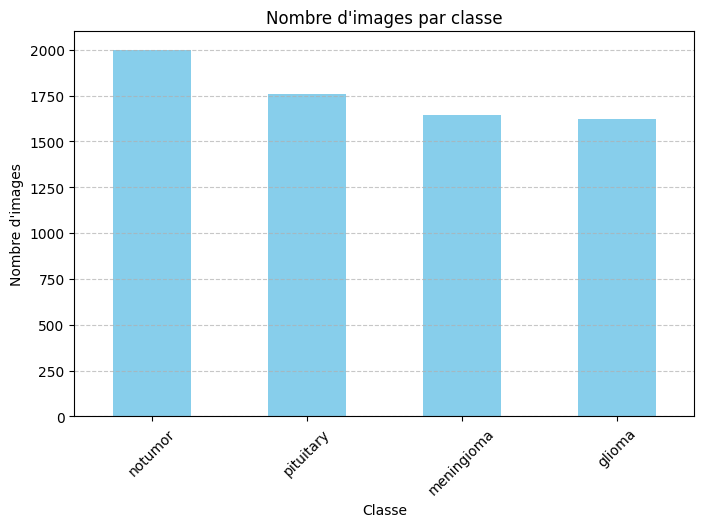

In [5]:
import matplotlib.pyplot as plt

# Visualiser sous forme de graphique
plt.figure(figsize=(8, 5))
counts.plot(kind='bar', color='skyblue')
plt.title("Nombre d'images par classe")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


        Montrer un échantillon d’images pour chaque classe.


Classe : meningioma


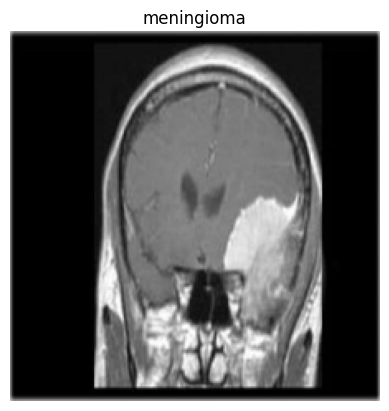

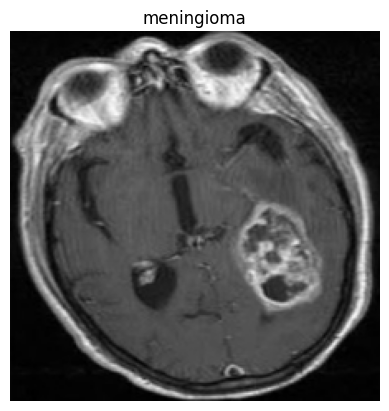

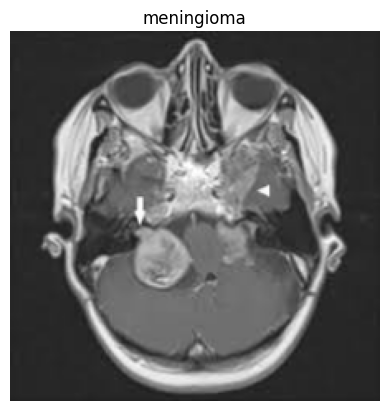

Classe : glioma


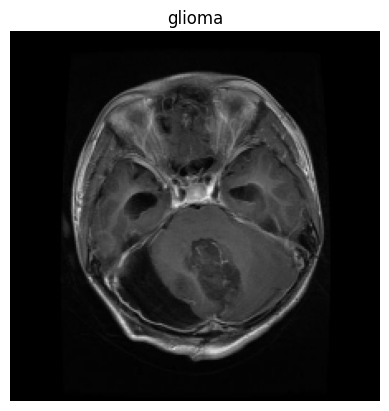

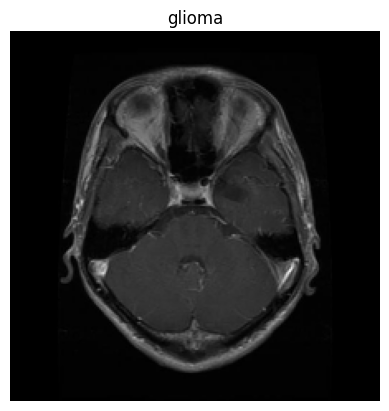

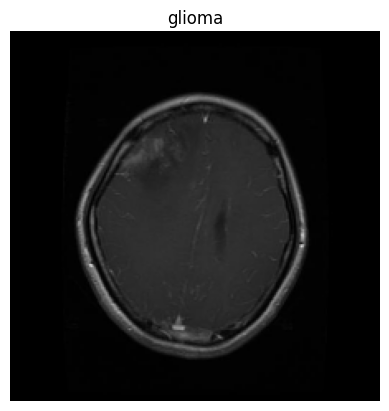

Classe : notumor


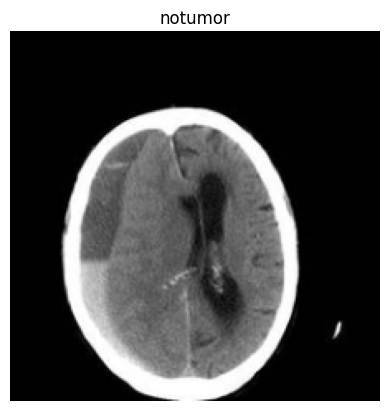

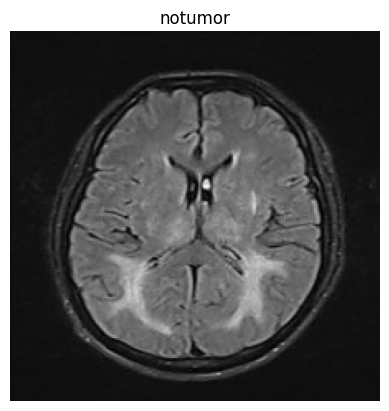

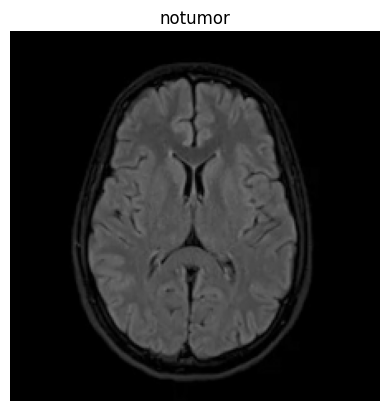

Classe : pituitary


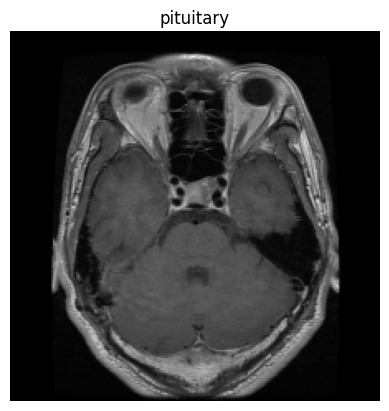

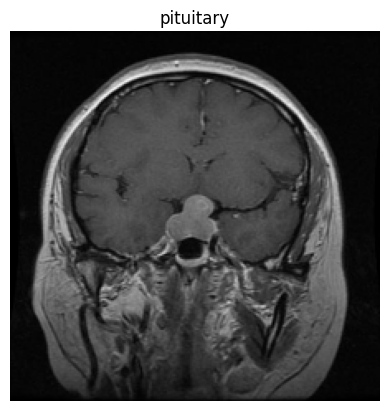

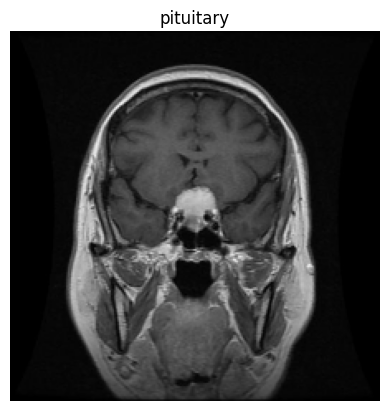

In [6]:
import matplotlib.pyplot as plt
import cv2

# Trouver les classes uniques
classes = list(set(labels_array))

for c in classes:
    print("Classe :", c)
    count = 0
    for i in range(len(labels_array)):
        if labels_array[i] == c:
            plt.imshow(cv2.cvtColor(imgs_array[i], cv2.COLOR_BGR2RGB))
            plt.title(c)
            plt.axis("off")
            plt.show()
            count += 1
            if count == 3:  # afficher seulement 3 images
                break


Avant équilibrage : Counter({np.str_('notumor'): 2000, np.str_('pituitary'): 1757, np.str_('meningioma'): 1645, np.str_('glioma'): 1621})
Après équilibrage : Counter({np.str_('glioma'): 2000, np.str_('meningioma'): 2000, np.str_('notumor'): 2000, np.str_('pituitary'): 2000})


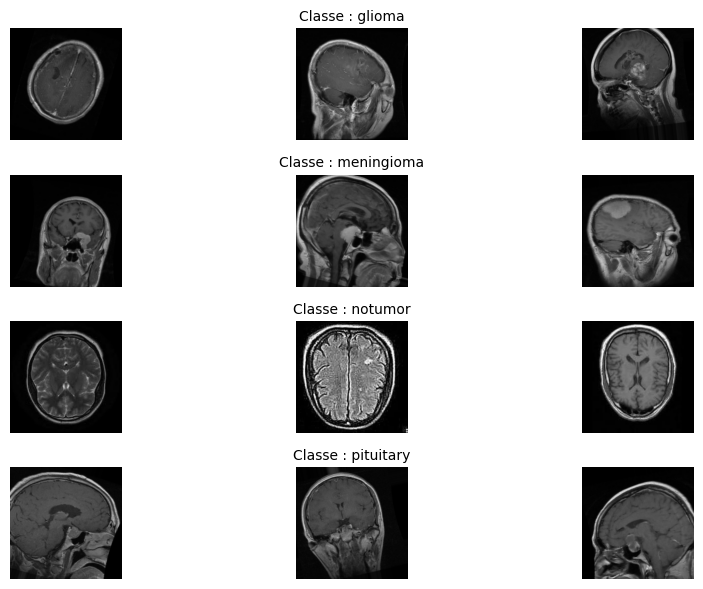

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Vérifier la distribution avant équilibrage
counts = Counter(labels_array)
print("Avant équilibrage :", counts)

# Trouver la taille maximale de classe
max_count = max(counts.values())



# Créer le générateur d’images avec data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,         
    width_shift_range=0.1,     
    height_shift_range=0.1,    
    zoom_range=0.1,            
    horizontal_flip=True       
)

new_imgs = []
new_labels = []

# Boucle pour équilibrer chaque classe
for c in counts.keys():
    images_class = imgs_array[labels_array == c]
    num_to_add = max_count - len(images_class)
    
    # Ajouter les images originales
    new_imgs.extend(list(images_class))
    new_labels.extend([c] * len(images_class))
    
    # Générer des images supplémentaires si besoin
    if num_to_add > 0:
        i = 0
        for batch in datagen.flow(images_class, batch_size=1):
            new_imgs.append(batch[0].astype(np.uint8))
            new_labels.append(c)
            i += 1
            if i >= num_to_add:
                break
# Transformer en numpy array
new_imgs = np.array(new_imgs)
new_labels = np.array(new_labels)

# Vérifier la distribution après équilibrage
print("Après équilibrage :", Counter(new_labels))

# ============================
#  Affichage de 3 images par classe
# ============================
classes = list(Counter(new_labels).keys())
plt.figure(figsize=(10, 6))

for idx, c in enumerate(classes):
    # Sélectionner 3 dernières images de cette classe
    imgs_class = new_imgs[new_labels == c]
    for i in range(1, 4):  # on prend les 3 dernières
        plt.subplot(len(classes), 3, idx * 3 + i)
        plt.imshow(imgs_class[-i].astype(np.uint8))  # <- ici on prend à partir de la fin
        plt.axis("off")
        if i == 2:
            plt.title(f"Classe : {c}", fontsize=10)

plt.tight_layout()
plt.show()



In [8]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Étape 1 : Encoder les labels texte → entiers
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(new_labels)

print(" Labels encodés (entiers) :", labels_encoded[:10])
print(" Classes correspondantes :", encoder.classes_)

# Étape 2 : Transformer en one-hot (catégoriel)
labels_categorical = to_categorical(labels_encoded)

print("\n Exemple de one-hot encoding :")
print(labels_categorical[:3])


 Labels encodés (entiers) : [0 0 0 0 0 0 0 0 0 0]
 Classes correspondantes : ['glioma' 'meningioma' 'notumor' 'pituitary']

 Exemple de one-hot encoding :
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [9]:
from sklearn.model_selection import train_test_split

# Division en 80% pour l'entraînement et 20% pour le test
X_train, X_test, y_train, y_test = train_test_split(
    new_imgs, labels_categorical, test_size=0.2, random_state=42, stratify=labels_encoded
)

print("Taille du jeu d'entraînement :", len(X_train))
print("Taille du jeu de test :", len(X_test))


Taille du jeu d'entraînement : 6400
Taille du jeu de test : 1600


In [10]:
# Normaliser les images entre 0 et 1
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Valeurs minimales :", X_train.min(), " | Valeurs maximales :", X_train.max())


Valeurs minimales : 0.0  | Valeurs maximales : 1.0


Conception du Modèle CNN

        Définir l’architecture CNN (Conv2D + MaxPooling + Dropout + Dense) avec des paramètres optimaux.


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Définir l'architecture du modèle
model = Sequential()

# 1ère couche convolutionnelle + pooling
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2ème couche convolutionnelle + pooling
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3ème couche convolutionnelle + pooling + dropout
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Aplatir les features maps pour les passer aux couches denses
model.add(Flatten())

# Couche dense avec Dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# 2eme  Couche dense avec Dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Couche de sortie (nombre de classes)
model.add(Dense(4, activation='softmax'))




        Choisir les meilleures fonctions d’activation pour les couches cachées et la couche de sortie.


In [12]:
# Couches cachées → activation='relu'
# Couche de sortie → activation='softmax'

        Utiliser les fonctions model.summary() et plot_model() pour vérifier l’architecture du modèle.

Résumé du modèle CNN :


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,177,476 (42.64 MB)

 Trainable params: 11,177,476 (42.64 MB)

 Non-trainable params: 0 (0.00 B)

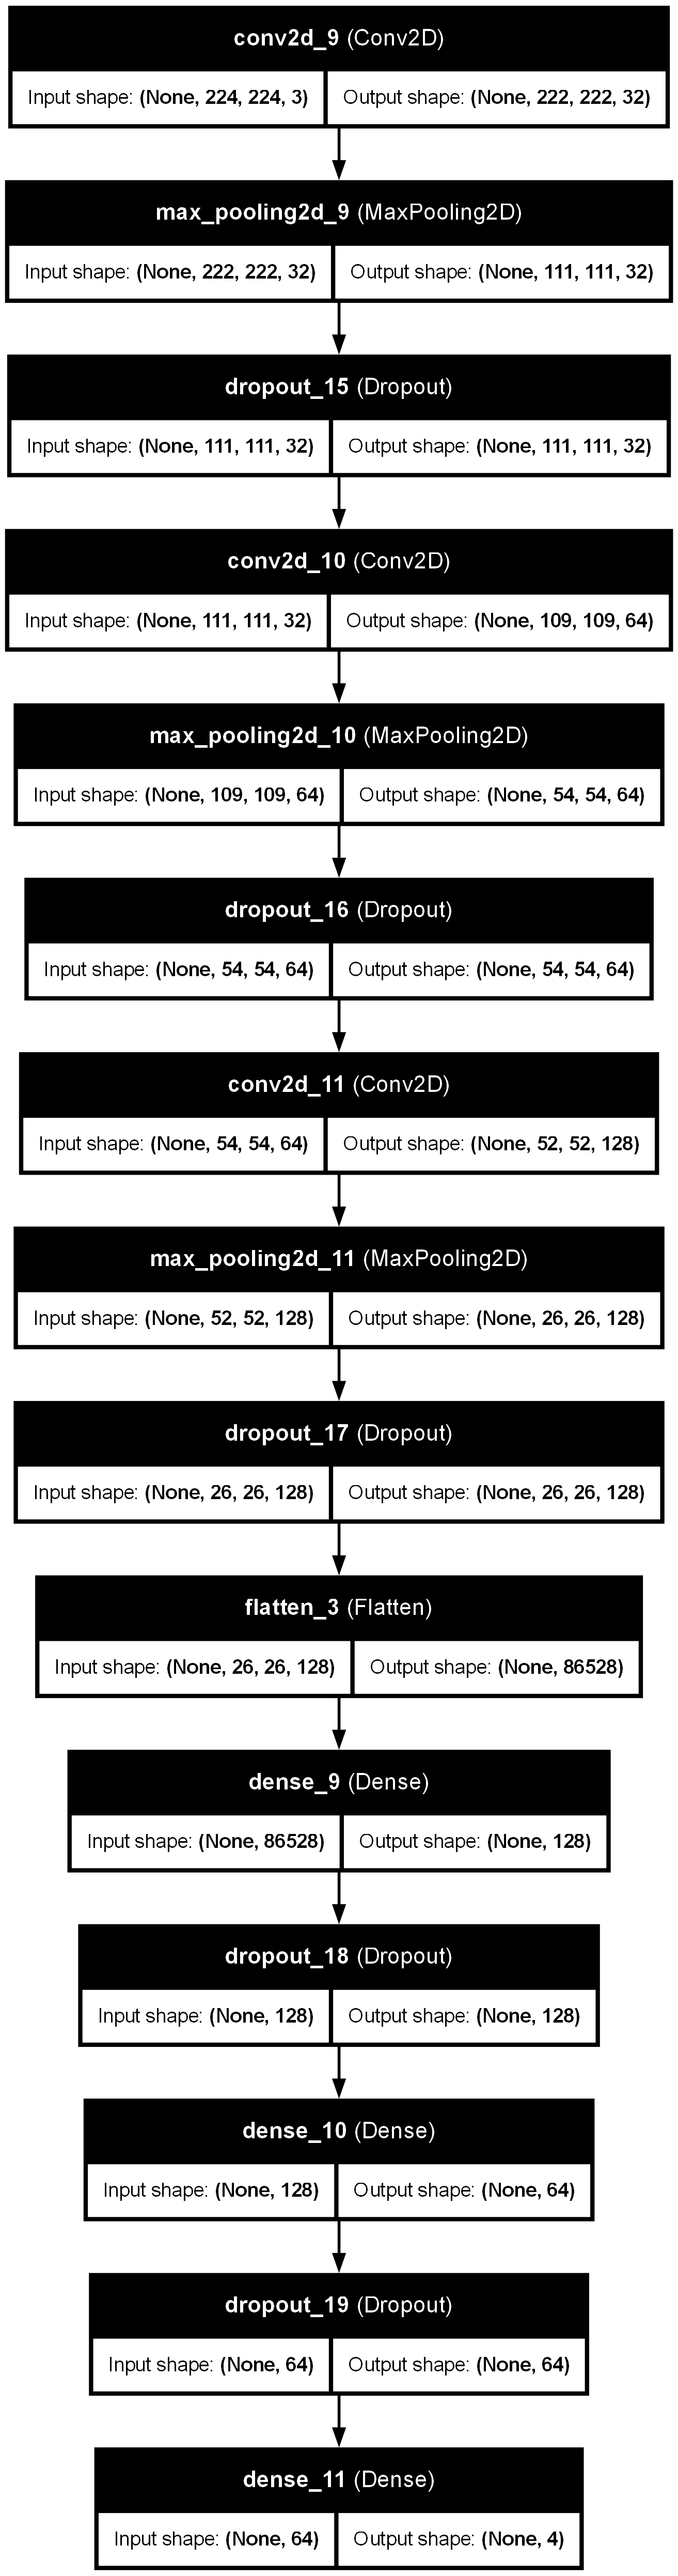

In [31]:
from tensorflow.keras.utils import plot_model


# 2️⃣ Affichage textuel de l’architecture
print("Résumé du modèle CNN :")
model.summary()

# Affichage graphique direct dans Jupyter
plot_model(model, show_shapes=True, show_layer_names=True)

        Compiler le modèle (ex. : Optimiseur Adam, fonction de perte categorical_crossentropy).

        Déterminer les hyperparamètres (taux d’apprentissage, nombre d’époques, taille de batch).

In [32]:
from tensorflow.keras.optimizers import Adam

# Définition des hyperparamètres
learning_rate = 0.001
epochs = 30
batch_size = 32

# Définir l’optimiseur
optimizer = Adam(learning_rate=learning_rate)

# Compiler le modèle
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Modèle compilé avec :")
print(f"- Learning rate : {learning_rate}")
print(f"- Époques : {epochs}")
print(f"- Batch size : {batch_size}")


✅ Modèle compilé avec :
- Learning rate : 0.001
- Époques : 30
- Batch size : 32


        Utiliser la bibliothèque time pour mesurer la durée de l’entraînement.

        Lancer l’entraînement avec model.fit().
        Sauvegarder le meilleur modèle à l’aide du callback ModelCheckpoint.


In [33]:
import time
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping


# Callback : sauvegarder le meilleur modèle
checkpoint = ModelCheckpoint(
    filepath='../model/best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Mesure du temps d’entraînement
start_time = time.time()

# Lancer l’entraînement
history = model.fit(
    X_train, y_train,                 # Données d'entraînement
    validation_data=(X_test, y_test), # Données de validation
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[checkpoint,early_stop],
    verbose=1
)

end_time = time.time()
training_time = end_time - start_time

print(f"\n Durée totale d'entraînement : {training_time:.2f} secondes")


Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.3709 - loss: 1.3376
Epoch 1: val_accuracy improved from None to 0.68063, saving model to ../model/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 54s 265ms/step - accuracy: 0.4759 - loss: 1.1350 - val_accuracy: 0.6806 - val_loss: 0.8226
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.6614 - loss: 0.7855
Epoch 2: val_accuracy improved from 0.68063 to 0.73813, saving model to ../model/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 84s 422ms/step - accuracy: 0.6839 - loss: 0.7442 - val_accuracy: 0.7381 - val_loss: 0.5953
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.7346 - loss: 0.6493
Epoch 3: val_accuracy did not improve from 0.73813
200/200 ━━━━━━━━━━━━━━━━━━━━ 110s 261ms/step - accuracy: 0.7437 - loss: 0.6334 - val_accuracy: 0.7075 - val_loss: 0.6224
Epoch 4/30
183/200 ━━━━━━━━━━━━━━━━━━━━ 9s 568ms/step - accuracy: 0.7856 - loss: 0.5167 
Epoch 4: val_accuracy improved from 0.73813 to 0.81687, saving model to ../model/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 102s 511ms/step - accuracy: 0.7897 - loss: 0.5247 - val_accuracy: 0.8169 - val_loss: 0.4500
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.8164 - loss: 0.4787
Epoch 5: val_accuracy improved from 0.81687 to 0.85500, saving model to ../model/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 69s 345ms/step - accuracy: 0.8133 - loss: 0.4779 - val_accuracy: 0.8550 - val_loss: 0.4003
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.8400 - loss: 0.4068
Epoch 6: val_accuracy did not improve from 0.85500
200/200 ━━━━━━━━━━━━━━━━━━━━ 76s 379ms/step - accuracy: 0.8452 - loss: 0.3979 - val_accuracy: 0.8544 - val_loss: 0.3480
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.8512 - loss: 0.3620
Epoch 7: val_accuracy improved from 0.85500 to 0.86563, saving model to ../model/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 98s 487ms/step - accuracy: 0.8552 - loss: 0.3637 - val_accuracy: 0.8656 - val_loss: 0.3646
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.8773 - loss: 0.3307
Epoch 8: val_accuracy improved from 0.86563 to 0.87187, saving model to ../model/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 77s 386ms/step - accuracy: 0.8789 - loss: 0.3160 - val_accuracy: 0.8719 - val_loss: 0.3373
Epoch 9/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.8847 - loss: 0.2924
Epoch 9: val_accuracy improved from 0.87187 to 0.89312, saving model to ../model/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 78s 392ms/step - accuracy: 0.8891 - loss: 0.2843 - val_accuracy: 0.8931 - val_loss: 0.3144
Epoch 10/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8953 - loss: 0.2767
Epoch 10: val_accuracy improved from 0.89312 to 0.90375, saving model to ../model/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 90s 453ms/step - accuracy: 0.9039 - loss: 0.2574 - val_accuracy: 0.9038 - val_loss: 0.2669
Epoch 11/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.9077 - loss: 0.2485
Epoch 11: val_accuracy did not improve from 0.90375
200/200 ━━━━━━━━━━━━━━━━━━━━ 112s 561ms/step - accuracy: 0.9172 - loss: 0.2272 - val_accuracy: 0.8919 - val_loss: 0.3262
Epoch 12/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9216 - loss: 0.2010
Epoch 12: val_accuracy did not improve from 0.90375
200/200 ━━━━━━━━━━━━━━━━━━━━ 69s 344ms/step - accuracy: 0.9211 - loss: 0.2060 - val_accuracy: 0.9031 - val_loss: 0.3169
Epoch 13/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9342 - loss: 0.1959
Epoch 13: val_accuracy improved from 0.90375 to 0.90938, saving model to ../model/best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 93s 465ms/step - accuracy: 0.9319 - loss: 0.1869 - val_accuracy: 0.9094 - val_loss: 0.2855
Epoch 14/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9300 - loss: 0.1734
Epoch 14: val_accuracy did not improve from 0.90938
200/200 ━━━━━━━━━━━━━━━━━━━━ 104s 275ms/step - accuracy: 0.9308 - loss: 0.1760 - val_accuracy: 0.8969 - val_loss: 0.3641
Epoch 15/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9422 - loss: 0.1617
Epoch 15: val_accuracy did not improve from 0.90938
200/200 ━━━━━━━━━━━━━━━━━━━━ 107s 535ms/step - accuracy: 0.9419 - loss: 0.1571 - val_accuracy: 0.9031 - val_loss: 0.3484
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.

 Durée totale d'entraînement : 1328.64 secondes


        Évaluer les performances sur l’ensemble de test.

In [34]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f" Résultats sur le jeu de test :")
print(f" Précision (accuracy) : {test_accuracy * 100:.2f}%")
print(f" Perte (loss) : {test_loss:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9038 - loss: 0.2669
 Résultats sur le jeu de test :
 Précision (accuracy) : 90.38%
 Perte (loss) : 0.2669


        Visualiser les courbes d’apprentissage (accuracy / loss).


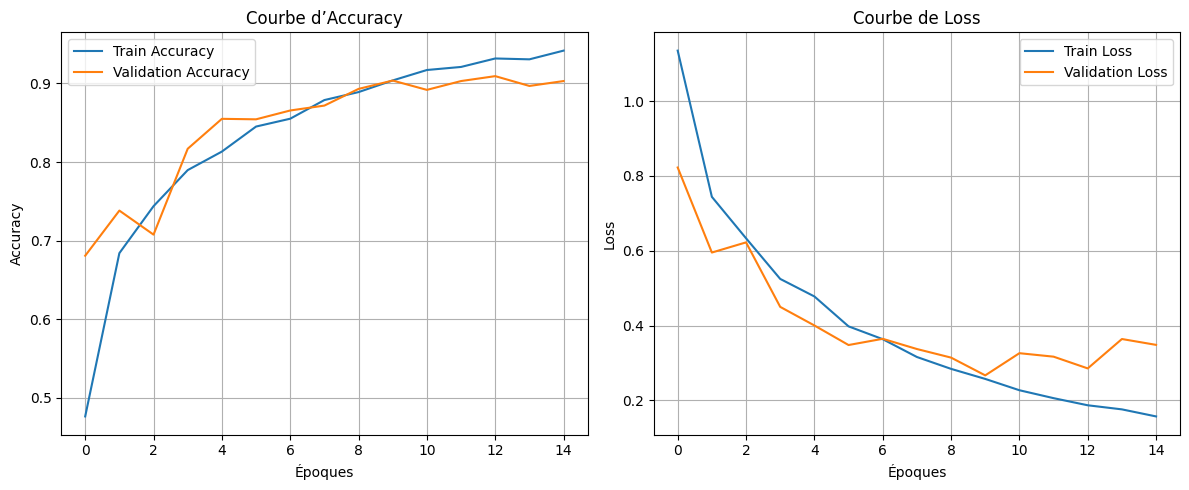

In [35]:
import matplotlib.pyplot as plt

# Afficher les courbes d'accuracy
plt.figure(figsize=(12, 5))

# ---- Courbe d'accuracy ----
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Courbe d’Accuracy')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# ---- Courbe de perte (loss) ----
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Courbe de Loss')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


        Générer une matrice de confusion et un rapport de classification.

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step


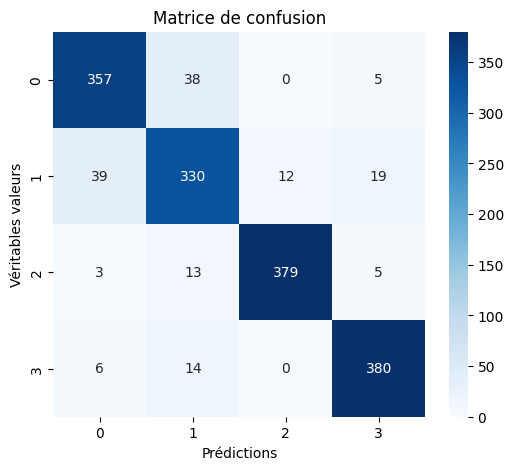

Rapport de classification :
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       400
           1       0.84      0.82      0.83       400
           2       0.97      0.95      0.96       400
           3       0.93      0.95      0.94       400

    accuracy                           0.90      1600
   macro avg       0.90      0.90      0.90      1600
weighted avg       0.90      0.90      0.90      1600



In [36]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#  Prédire sur les données de test
y_pred = model.predict(X_test)

#  Convertir les prédictions et labels en classes
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

#  Matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

#  Visualisation
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Véritables valeurs')
plt.title('Matrice de confusion')
plt.show()

#  Rapport de classification
print("Rapport de classification :")
print(classification_report(y_true, y_pred_classes))


        Afficher des exemples de prédictions correctes et incorrectes.

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step


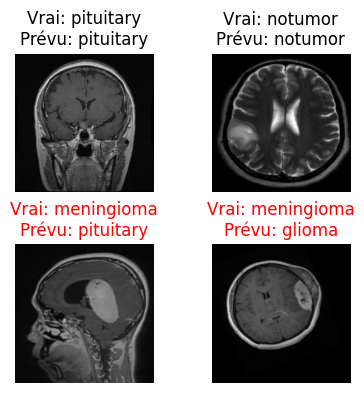

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Conversion du one-hot vers les entiers
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)

# Trouver indices des prédictions correctes et incorrectes
correct_idx = np.where(y_true == y_pred)[0]
incorrect_idx = np.where(y_true != y_pred)[0]

# Afficher 2 exemples corrects
plt.figure(figsize=(10, 4))
for i, idx in enumerate(correct_idx[:2]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"Vrai: {encoder.classes_[y_true[idx]]}\nPrévu: {encoder.classes_[y_pred[idx]]}")
    plt.axis("off")

# Afficher 2 exemples incorrects
for i, idx in enumerate(incorrect_idx[:2]):
    plt.subplot(2, 5, i + 6)
    plt.imshow(X_test[idx])
    plt.title(f"Vrai: {encoder.classes_[y_true[idx]]}\nPrévu: {encoder.classes_[y_pred[idx]]}", color='red')
    plt.axis("off")

plt.tight_layout()
plt.show()


In [18]:
print(encoder.classes_)


['glioma' 'meningioma' 'notumor' 'pituitary']


In [38]:
model.save('../model/model_cnn.keras')